<a href="https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/notebooks/model_sepration_without_endpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to separate Stable Diffusion into three different parts(encoder, diffusion model, decoder) in isolated manner. The purpose of this notebook is to deploy each part on different endpoint and generate images by interacting with each parts. 

# Setup

## Install dependencies for local dev environment


In [ ]:
!pip install tensorflow==2.11
!pip install keras-cv==0.4.0
!pip install tensorflow_datasets

# Model Separation

Here are how each part is separated:
1. Encoder: It takes an input `prompt`, encodes the `prompt` with `SimpleTokenizer`, and  creates `context` and `unconditional_context`.

2. Diffusion Model: It creates initial diffusion noise, then iteratively generates latent space based on `timesteps`, `context`, `unconditional_context`, and the initial diffusion noise.

3. Decoder: It takes the resulting latent space, upscale it up to `512x512` size of images.



## Encoder

In [3]:
import tensorflow as tf

from tensorflow import keras
from keras_cv.models.stable_diffusion.text_encoder import TextEncoderV2
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS

BATCH_SIZE = 4
MAX_PROMPT_LENGTH = 77

tokenizer = SimpleTokenizer()
text_encoder = TextEncoderV2(MAX_PROMPT_LENGTH)
text_encoder_weights_fpath = keras.utils.get_file(
    origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_encoder.h5",
    file_hash="4789e63e07c0e54d6a34a29b45ce81ece27060c499a709d556c7755b42bb0dc4",
)
text_encoderv2_weights_fpath = keras.utils.get_file(
    origin="https://huggingface.co/ianstenbit/keras-sd2.1/resolve/main/text_encoder_v2_1.h5",
    file_hash="985002e68704e1c5c3549de332218e99c5b9b745db7171d5f31fcd9a6089f25b",
)
text_encoder.load_weights(text_encoderv2_weights_fpath)
pos_ids = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

prompt = "photograph of an astronaut riding a horse"

def _get_unconditional_context():
    unconditional_tokens = tf.convert_to_tensor(
        [_UNCONDITIONAL_TOKENS], dtype=tf.int32
    )
    unconditional_context = text_encoder.predict_on_batch(
        [unconditional_tokens, pos_ids]
    )

    return unconditional_context

def encode_text(prompt):
  # Tokenize prompt (i.e. starting context)
  inputs = tokenizer.encode(prompt)
  print(inputs)
  phrase = inputs + [49407] * (MAX_PROMPT_LENGTH - len(inputs))
  phrase = tf.convert_to_tensor([phrase], dtype=tf.int32)

  context = text_encoder.predict_on_batch([phrase, pos_ids])

  return context  

def get_contexts(encoded_text, batch_size):
    encoded_text = tf.squeeze(encoded_text)
    if encoded_text.shape.rank == 2:
        encoded_text = tf.repeat(
            tf.expand_dims(encoded_text, axis=0), batch_size, axis=0
        )

    context = encoded_text

    unconditional_context = tf.repeat(
        _get_unconditional_context(), batch_size, axis=0
    )  

    return context, unconditional_context

print(prompt)
encoded_text = encode_text(prompt)
context, unconditional_context = get_contexts(encoded_text, BATCH_SIZE)

photograph of an astronaut riding a horse
[49406, 8853, 539, 550, 18376, 6765, 320, 4558, 49407]


## Diffusion Model

In [4]:
import math
import tensorflow as tf
from tensorflow import keras

from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModelV2

seed = None

img_height = 512
img_width = 512
img_height = round(img_height / 128) * 128
img_width = round(img_width / 128) * 128

num_steps = 25
unconditional_guidance_scale = 7.5

MAX_PROMPT_LENGTH = 77
BATCH_SIZE = 4

diffusion_model = DiffusionModelV2(img_height, img_width, MAX_PROMPT_LENGTH)
diffusion_model_weights_fpath = keras.utils.get_file(
    origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_diffusion_model.h5",
    file_hash="8799ff9763de13d7f30a683d653018e114ed24a6a819667da4f5ee10f9e805fe",
)
diffusion_modelv2_weights_fpath = keras.utils.get_file(
    origin="https://huggingface.co/ianstenbit/keras-sd2.1/resolve/main/diffusion_model_v2_1.h5",
    file_hash="c31730e91111f98fe0e2dbde4475d381b5287ebb9672b1821796146a25c5132d",
)
diffusion_model.load_weights(diffusion_modelv2_weights_fpath)

def _get_initial_diffusion_noise(batch_size, seed):
    if seed is not None:
        return tf.random.stateless_normal(
            (batch_size, img_height // 8, img_width // 8, 4),
            seed=[seed, seed],
        )
    else:
        return tf.random.normal(
            (batch_size, img_height // 8, img_width // 8, 4)
        )

def _get_initial_alphas(timesteps):
    alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
    alphas_prev = [1.0] + alphas[:-1]

    return alphas, alphas_prev

def _get_timestep_embedding(timestep, batch_size, dim=320, max_period=10000):
    half = dim // 2
    freqs = tf.math.exp(
        -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
    )
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    embedding = tf.reshape(embedding, [1, -1])
    return tf.repeat(embedding, batch_size, axis=0)

latent = _get_initial_diffusion_noise(BATCH_SIZE, seed)

# Iterative reverse diffusion stage
timesteps = tf.range(1, 1000, 1000 // num_steps)
alphas, alphas_prev = _get_initial_alphas(timesteps)

progbar = keras.utils.Progbar(len(timesteps))
iteration = 0
for index, timestep in list(enumerate(timesteps))[::-1]:
    latent_prev = latent  # Set aside the previous latent vector
    t_emb = _get_timestep_embedding(timestep, BATCH_SIZE)
    unconditional_latent = diffusion_model.predict_on_batch(
        [latent, t_emb, unconditional_context]
    )
    latent = diffusion_model.predict_on_batch([latent, t_emb, context])
    latent = unconditional_latent + unconditional_guidance_scale * (
        latent - unconditional_latent
    )
    a_t, a_prev = alphas[index], alphas_prev[index]
    pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(a_t)
    latent = latent * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0
    iteration += 1
    progbar.update(iteration)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


25/25 [==============================] - 93s 3s/step


## Decoder

In [7]:
import numpy as np
from keras_cv.models.stable_diffusion.decoder import Decoder

img_height = 512
img_width = 512
img_height = round(img_height / 128) * 128
img_width = round(img_width / 128) * 128

decoder = Decoder(img_height, img_width)
decoder_weights_fpath = keras.utils.get_file(
    origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_decoder.h5",
    file_hash="ad350a65cc8bc4a80c8103367e039a3329b4231c2469a1093869a345f55b1962",
)
decoder.load_weights(decoder_weights_fpath)

decoded = decoder.predict_on_batch(latent)
decoded = ((decoded + 1) / 2) * 255
images = np.clip(decoded, 0, 255).astype("uint8")

# Display the generated images

In [8]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

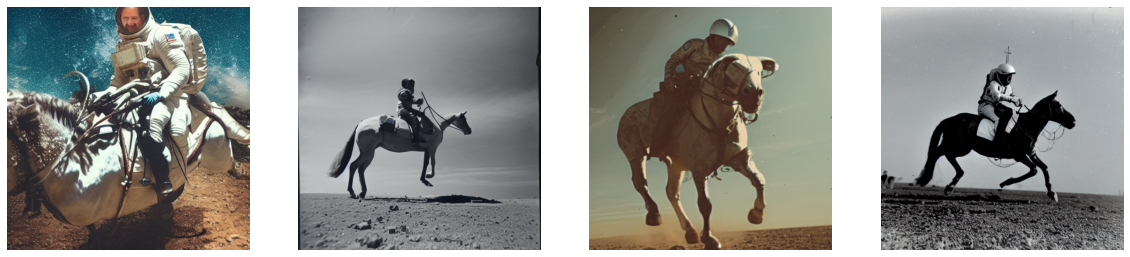

In [9]:
plot_images(images)